In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [7]:
from spin import *

In [8]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator
from qiskit.quantum_info import partial_trace as partial_trace_qiskit
from qiskit.quantum_info import entropy as entropy_qiskit 

import numpy as np
# from trotter import *
import time

In [52]:
simulator_gpu = AerSimulator(method='statevector', device='CPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

('CPU',)
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')


In [51]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

def init_system(n, alpha): 
    n = n

    # QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)
    powerlaw = Power_Law(n, alpha=alpha, Jx=1, Jy=1, Jz=1, hx=1, hy=1, hz=1, pbc=False, verbose=True)

    # H = QIMF.ham_xyz
    H = powerlaw.ham_xyz
    print(H)

    init = Statevector.from_label("10"*int(n/2))
    t = 10
    r = 100
    m = 1
    dt = (t / r)
    dt2 = (t / (r*m))

    print(dt, dt2)
    return H, init, n, r, m, dt, dt2

In [53]:
import numpy as cp
from typing import List

def partial_trace (psi: cp.ndarray, keep: List[int], n_qubits: int) -> cp.ndarray:
    psi = psi / cp.linalg.norm(psi)

    traced_out = [i for i in range(n_qubits) if i not in keep]
    dim_keep = 2 ** len(keep)
    dim_traced = 2 ** len(traced_out)
    psi = psi.reshape([2] * n_qubits)
    perm = keep + traced_out
    psi = psi.transpose(perm)
    psi = psi.reshape(dim_keep, dim_traced)

    rho_A = psi @ psi.conj().T
    return rho_A

In [54]:
def entropy(rho):
    eigvals = cp.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 0]
    entropy = -cp.sum(eigvals * cp.log2(eigvals))
    # return entropy.get() 
    return entropy 

In [19]:
import numpy as np
from scipy.linalg import sqrtm

def trotter_error(better_states, states, r, metric):
    errors = []
    
    for i in range (r): 
        b = better_states[i]
        s = states[i]
        if metric == "norm":
            err = np.linalg.norm(b - s) 
    
        elif metric == "infidelity":
            overlap = np.vdot(b, s)
            err = 1 - np.abs(overlap)**2
    
        elif metric == "dm":
            dm_ideal = np.outer(b, b.conj())
            dm_trotter = np.outer(s, s.conj())
            err = np.linalg.norm(dm_ideal - dm_trotter)
    
        elif metric == "trace":
            b = np.outer(b, b.conj())
            s = np.outer(s, s.conj())
            diff = b - s
            sqrt_term = sqrtm(diff.conj().T @ diff)
            err = 0.5 * np.trace(sqrt_term).real

        errors.append(err)
    return errors

In [ ]:
from qiskit.synthesis import SuzukiTrotter
def simulation(init, n, r, m, dt, dt2, H): 
    trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())

    trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())

    start_time = time.time()
    data, data2 = [], []
    ideal_psi = init
    total_steps = r*m - 1
    tro = [] 

    for s in range(1, r+1):
        circ_pf1 = QuantumCircuit(n)
        circ_pf1.set_statevector(ideal_psi.data)
        circ_pf1.append(trotter_step_first_order, range(n))
        circ_pf1.save_statevector(label=f"sv_{s}")

        circ_pf1 = circ_pf1.decompose(reps=2)
        res = simulator_gpu.run(circ_pf1).result()
        psi = res.data(0)[f"sv_{s}"]
        data.append(psi)

        for ss in range (1, m+1):
            # print("step:", ss)
            circ_pf2 = QuantumCircuit(n)
            circ_pf2.set_statevector(ideal_psi.data)

            circ_pf2.append(trotter_step_second_order, range(n))
            circ_pf2 = circ_pf2.decompose(reps=2)

            circ_pf2.save_statevector(label=f"temp_{total_steps}")

            res2 = simulator_gpu.run(circ_pf2).result()
            temp = res2.data(0)[f"temp_{total_steps}"]
            ideal_psi = temp
            # print(f"temp_{ss}")
            total_steps -= 1

        ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
        data2.append(ideal_psi)

        tro.append(np.linalg.norm(ideal_psi - psi))

    better_states = data2
    states = data
    
    entropy_list = []
    entropy_list2 = []

    for s in range(1, r+1):
        state = cp.asarray(states[s-1].data)
        rdm1 = partial_trace((state), list(range(1)), n)
        rdm2 = partial_trace((state), list(range(2)), n)
        rdm3 = partial_trace((state), list(range(3)), n)
        rdm4 = partial_trace((state), list(range(4)), n)
        temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
        print(s, temp_entropy)

        better = cp.asarray(better_states[s-1].data) 
        rdm12 = partial_trace((better), list(range(1)), n)
        rdm22 = partial_trace((better), list(range(2)), n)
        rdm32 = partial_trace((better), list(range(3)), n)
        rdm42 = partial_trace((better), list(range(4)), n)
        temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
        print(temp_entropy2)

        entropy_list.append(temp_entropy)
        entropy_list2.append(temp_entropy2)

    total_time = time.time() - start_time
    print("total time", total_time)

    return entropy_list, entropy_list2, tro

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot(entropy_list, entropy_list2, t_error, alpha, n): 
    dt = 0.1
    steps = len(entropy_list)
    times = np.linspace(0, 10, 100)

    entropy_values_1 = [entropy[0] for entropy in entropy_list]
    entropy_values_2 = [entropy[1] for entropy in entropy_list]
    entropy_values_3 = [entropy[2] for entropy in entropy_list]
    entropy_values_4 = [entropy[3] for entropy in entropy_list]

    entropy_values_12 = [entropy[0] for entropy in entropy_list2]
    entropy_values_22 = [entropy[1] for entropy in entropy_list2]
    entropy_values_32 = [entropy[2] for entropy in entropy_list2]
    entropy_values_42 = [entropy[3] for entropy in entropy_list2]

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 5))
    # Create the plot
    axes[0].plot(times, entropy_values_1)
    axes[0].plot(times, entropy_values_2)
    axes[0].plot(times, entropy_values_3)
    axes[0].plot(times, entropy_values_4) 
    axes[0].plot(times, entropy_values_12, label='typical 1-RDM, pf2')
    axes[0].plot(times, entropy_values_22, label='typical 2-RDM, pf2')
    axes[0].plot(times, entropy_values_32, label='typical 3-RDM, pf2')
    axes[0].plot(times, entropy_values_42, label='typical 4-RDM, pf2')

    axes[1].plot(times, t_error, linestyle=":") 

    axes[1].set_ylabel("trotter error")

    axes[1].set_xlabel("Time")
    axes[0].set_ylabel(f"Entropy with alpha = {alpha}, n = {n}")
    axes[0].legend()


In [75]:
n = 8
alpha = 4
H, init, n, r, m, dt, dt2 = init_system(n, alpha) 
entropy_list_4, entropy_list2_4, t_error_4 = simulation(init, n, r, m, dt, dt2, H)

The Hamiltonian: 
 SparsePauliOp(['IIIIIIXX', 'IIIIIXIX', 'IIIIXIIX', 'IIIXIIIX', 'IIXIIIIX', 'IXIIIIIX', 'XIIIIIIX', 'IIIIIXXI', 'IIIIXIXI', 'IIIXIIXI', 'IIXIIIXI', 'IXIIIIXI', 'XIIIIIXI', 'IIIIXXII', 'IIIXIXII', 'IIXIIXII', 'IXIIIXII', 'XIIIIXII', 'IIIXXIII', 'IIXIXIII', 'IXIIXIII', 'XIIIXIII', 'IIXXIIII', 'IXIXIIII', 'XIIXIIII', 'IXXIIIII', 'XIXIIIII', 'XXIIIIII', 'IIIIIIYY', 'IIIIIYIY', 'IIIIYIIY', 'IIIYIIIY', 'IIYIIIIY', 'IYIIIIIY', 'YIIIIIIY', 'IIIIIYYI', 'IIIIYIYI', 'IIIYIIYI', 'IIYIIIYI', 'IYIIIIYI', 'YIIIIIYI', 'IIIIYYII', 'IIIYIYII', 'IIYIIYII', 'IYIIIYII', 'YIIIIYII', 'IIIYYIII', 'IIYIYIII', 'IYIIYIII', 'YIIIYIII', 'IIYYIIII', 'IYIYIIII', 'YIIYIIII', 'IYYIIIII', 'YIYIIIII', 'YYIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZI

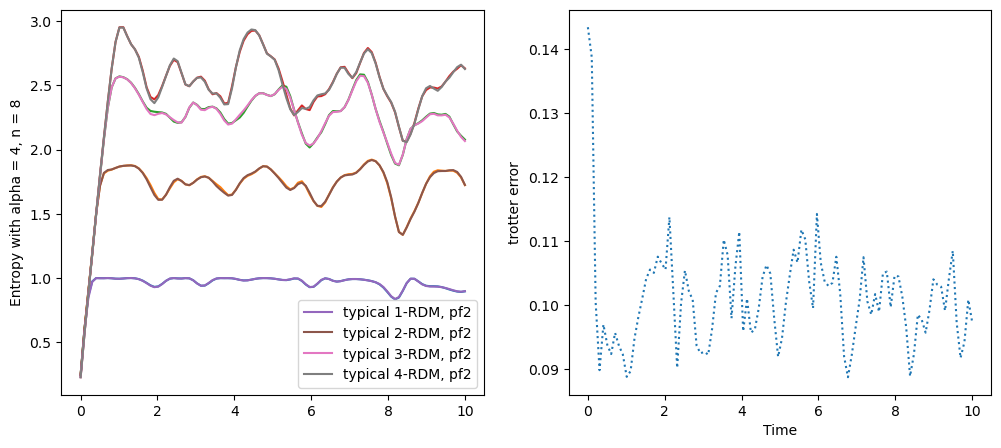

In [ ]:
plot(entropy_list_4, entropy_list2_4, t_error_4, alpha, n)

In [71]:
n = 8
alpha = 1
H, init, n, r, m, dt, dt2 = init_system(n, alpha) 
entropy_list_1, entropy_list2_1, t_error_1 = simulation(init, n, r, m, dt, dt2, H)

The Hamiltonian: 
 SparsePauliOp(['IIIIIIXX', 'IIIIIXIX', 'IIIIXIIX', 'IIIXIIIX', 'IIXIIIIX', 'IXIIIIIX', 'XIIIIIIX', 'IIIIIXXI', 'IIIIXIXI', 'IIIXIIXI', 'IIXIIIXI', 'IXIIIIXI', 'XIIIIIXI', 'IIIIXXII', 'IIIXIXII', 'IIXIIXII', 'IXIIIXII', 'XIIIIXII', 'IIIXXIII', 'IIXIXIII', 'IXIIXIII', 'XIIIXIII', 'IIXXIIII', 'IXIXIIII', 'XIIXIIII', 'IXXIIIII', 'XIXIIIII', 'XXIIIIII', 'IIIIIIYY', 'IIIIIYIY', 'IIIIYIIY', 'IIIYIIIY', 'IIYIIIIY', 'IYIIIIIY', 'YIIIIIIY', 'IIIIIYYI', 'IIIIYIYI', 'IIIYIIYI', 'IIYIIIYI', 'IYIIIIYI', 'YIIIIIYI', 'IIIIYYII', 'IIIYIYII', 'IIYIIYII', 'IYIIIYII', 'YIIIIYII', 'IIIYYIII', 'IIYIYIII', 'IYIIYIII', 'YIIIYIII', 'IIYYIIII', 'IYIYIIII', 'YIIYIIII', 'IYYIIIII', 'YIYIIIII', 'YYIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZI

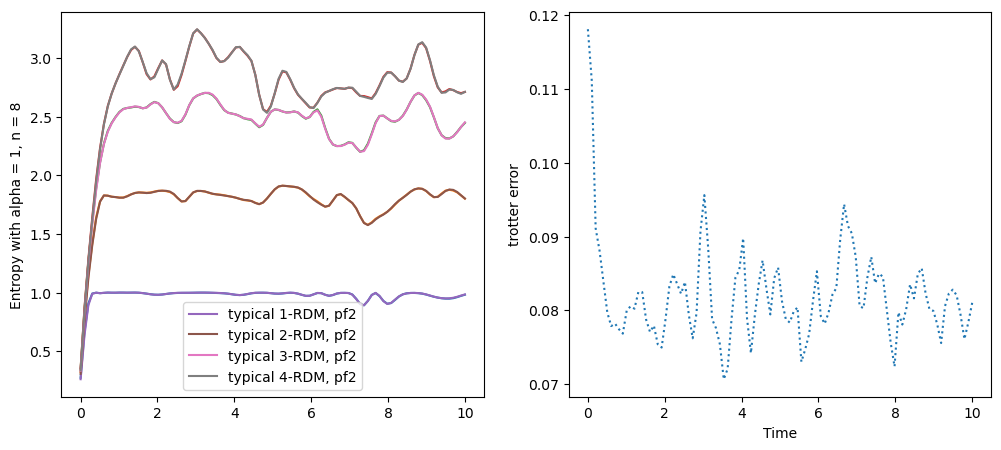

In [72]:
plot(entropy_list_1, entropy_list2_1, t_error_1, alpha, 8)


In [73]:
n = 8
alpha = 8
H, init, n, r, m, dt, dt2 = init_system(n, alpha) 
entropy_list_8, entropy_list2_8, t_error_8 = simulation(init, n, r, m, dt, dt2, H)

The Hamiltonian: 
 SparsePauliOp(['IIIIIIXX', 'IIIIIXIX', 'IIIIXIIX', 'IIIXIIIX', 'IIXIIIIX', 'IXIIIIIX', 'XIIIIIIX', 'IIIIIXXI', 'IIIIXIXI', 'IIIXIIXI', 'IIXIIIXI', 'IXIIIIXI', 'XIIIIIXI', 'IIIIXXII', 'IIIXIXII', 'IIXIIXII', 'IXIIIXII', 'XIIIIXII', 'IIIXXIII', 'IIXIXIII', 'IXIIXIII', 'XIIIXIII', 'IIXXIIII', 'IXIXIIII', 'XIIXIIII', 'IXXIIIII', 'XIXIIIII', 'XXIIIIII', 'IIIIIIYY', 'IIIIIYIY', 'IIIIYIIY', 'IIIYIIIY', 'IIYIIIIY', 'IYIIIIIY', 'YIIIIIIY', 'IIIIIYYI', 'IIIIYIYI', 'IIIYIIYI', 'IIYIIIYI', 'IYIIIIYI', 'YIIIIIYI', 'IIIIYYII', 'IIIYIYII', 'IIYIIYII', 'IYIIIYII', 'YIIIIYII', 'IIIYYIII', 'IIYIYIII', 'IYIIYIII', 'YIIIYIII', 'IIYYIIII', 'IYIYIIII', 'YIIYIIII', 'IYYIIIII', 'YIYIIIII', 'YYIIIIII', 'IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IIIZIIIZ', 'IIZIIIIZ', 'IZIIIIIZ', 'ZIIIIIIZ', 'IIIIIZZI', 'IIIIZIZI', 'IIIZIIZI', 'IIZIIIZI', 'IZIIIIZI', 'ZIIIIIZI', 'IIIIZZII', 'IIIZIZII', 'IIZIIZII', 'IZIIIZII', 'ZIIIIZII', 'IIIZZIII', 'IIZIZIII', 'IZIIZIII', 'ZIIIZIII', 'IIZZIIII', 'IZIZIIII', 'ZIIZI

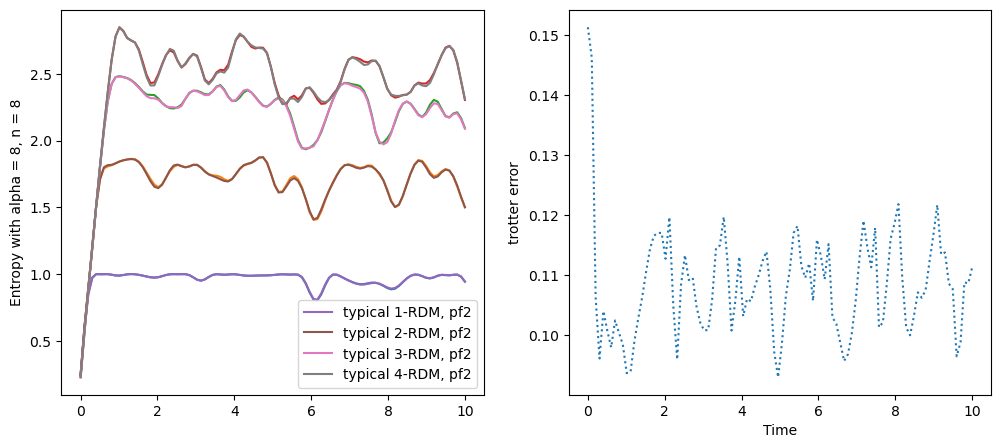

In [74]:
plot(entropy_list_8, entropy_list2_8, t_error_8, alpha, 8)


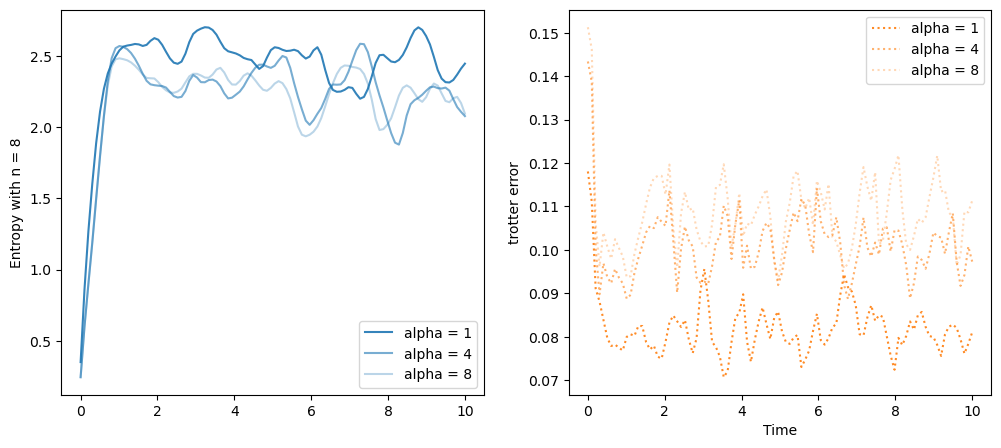

In [82]:
entropy_values_1 = [entropy[2] for entropy in entropy_list_1]
entropy_values_4 = [entropy[2] for entropy in entropy_list_4]
entropy_values_8 = [entropy[2] for entropy in entropy_list_8]

# plt.plot(entropy_values_4, label='ideal 3-RDM, alpha=4')
# plt.plot(entropy_values_1, label='ideal 3-RDM, alpha=1')
# plt.plot(entropy_values_8, label='ideal 3-RDM, alpha=8') 

times = np.linspace(0, 10, 100) 

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 5))
# Create the plot
axes[0].plot(times, entropy_values_1, label='alpha = 1', color='tab:blue', alpha=0.9)
axes[0].plot(times, entropy_values_4, label='alpha = 4', color='tab:blue', alpha=0.6)
axes[0].plot(times, entropy_values_8, label='alpha = 8', color='tab:blue', alpha=0.3)

axes[1].plot(times, t_error_1, linestyle=":", label ='alpha = 1', color='tab:orange', alpha=0.9)
axes[1].plot(times, t_error_4, linestyle=":", label = 'alpha = 4', color='tab:orange', alpha=0.6)
axes[1].plot(times, t_error_8, linestyle=":", label = 'alpha = 8', color='tab:orange', alpha=0.3)


axes[1].set_ylabel("trotter error")

axes[1].set_xlabel("Time")
axes[1].legend()
axes[0].set_ylabel(f"Entropy with n = {n}")
axes[0].legend()

In [19]:
!python --version

Python 3.8.13
